# Roadway and Speed Identification from Satellite Images  

This notebook is a stream-lined version of the AWS Tutorial: [Deep Learning on AWS Open Data Registry: Automatic Building and Road Extraction from Satellite and LiDAR](https://github.com/aws-samples/aws-open-data-satellite-lidar-tutorial). In addition to simplifying the code, we also explore the business value of such a model.

## Set Up

After cell finishes, change Kernel to "conda_tutorial_env" (may need to wait a bit and refresh page).

In [1]:
!./setup-env.sh tutorial_env

from IPython.display import clear_output
clear_output()
print()

#### Import Dependencies

In [1]:
import os, time, json, random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import skimage
import torch
from torch import nn
import networkx as nx

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The below package was customized by AWS and updated by us for this tutorial. Additional information is available in the libs folder.

In [2]:
import libs.solaris as sol

#### Plotting Preferences

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

## Download Data from S3  
This tutorial uses  S3 bucket is publically available to all and in an S3 bucket hosted by Amazon. In total, the data download is more than 60GB large, so the notebook much have a volume size at least that large.  

The dataset is satellite images from around Las Vegas. In addition to the satellite photos, there is Lidar image data which indicates height of objects on the Earth and different materials based on how laser light is reflected back from the surface. The reflectivity of road surfaces is different from the surrounding surfaces, which we will use in our model. The labeled data is a mask of road map data that is color coded based on the speed limit on that portion of the road.

In [14]:
!./download-from-s3.sh

===== Downloading RGB+LiDAR merged data (~22GB) ... =====
===== Downloading pretrained model weights (617MB) ... =====
===== Downloading completes. =====


## Data Exploration

In [4]:
data_dir = './data/roads/'
img_dir = os.path.join(data_dir, 'RGB+INTEN')
mask_dir = os.path.join(data_dir, 'mask_roads_speed')
mask_mc_dir = os.path.join(data_dir, 'mask_roads_speed_mc')

prefix = 'SN3_roads_train_AOI_2_Vegas_'

In [55]:
# Road plotting parameters
speed_colors = [36, 72, 108, 144, 180, 216, 252]
speed_names = ['1-10 mph','11-20 mph','21-30 mph','31-40 mph','41-50 mph','51-60 mph','61-65 mph','full map']
road_mask_params = {'vmin': 0, 'vmax': 255, 'cmap': 'YlOrRd', 'interpolation': 'none'}

### Example Plots of Data

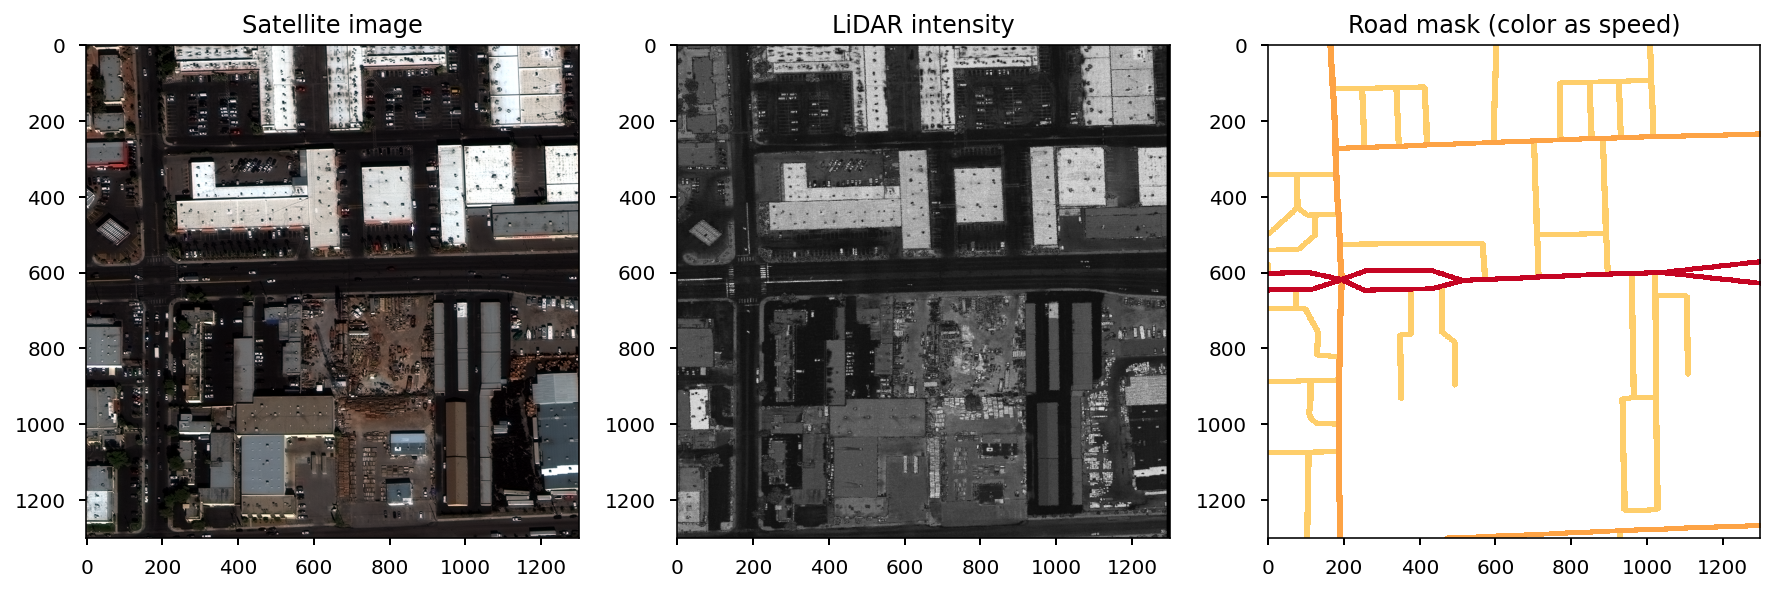

In [26]:
sample = 'img1136'

# Read in 4-channel image from GeoTIFF.
img_file = prefix + 'RGB+INTEN_' + sample + '.tif'
img_path = os.path.join(img_dir, img_file)
img = skimage.io.imread(img_path)
rgb = img[..., :3]
inten = img[..., -1]

# Read in road mask images. Note that these masks were binned
# into multiple speed bins. In this case, there are 7 categories.
mask_file = img_file.replace('RGB+INTEN', 'mask_roads_speed')
mask_path = os.path.join(mask_dir, mask_file)
mask = skimage.io.imread(mask_path)

# Display satellite image and road mask.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb)
ax[0].set_title('Satellite image')
ax[1].imshow(inten, cmap='gray', vmin=0, vmax=5000)
ax[1].set_title('LiDAR intensity')
ax[2].imshow(mask, alpha=(mask>0).astype('float'), **road_mask_params)
ax[2].set_title('Road mask (color as speed)')
fig.show()

The road network mask is further broken down into the portions of the network in each of the 7 speed limit categories. They are displayed below, along with the whole map in the 8th subplot.

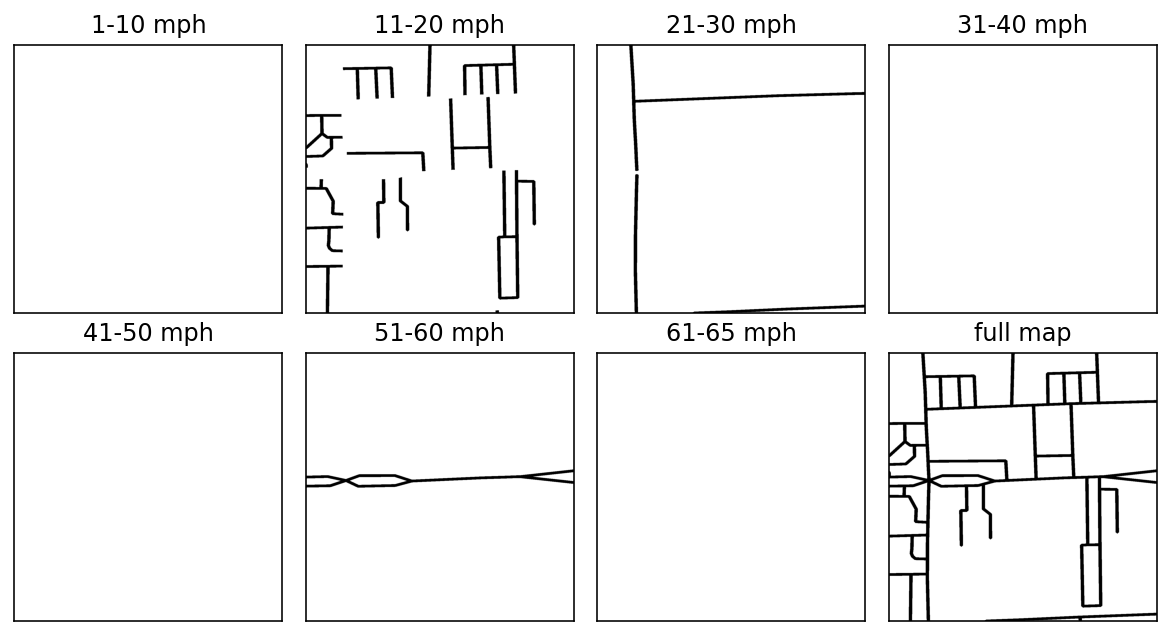

In [58]:
mask_mc_file = img_file.replace('RGB+INTEN', 'mask_roads_speed_mc')
mask_mc_path = os.path.join(mask_mc_dir, mask_mc_file)
mask_mc = skimage.io.imread(mask_mc_path)

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.15)
for i in range(mask_mc.shape[-1]):
    row = i // ax.shape[-1]
    col = i % ax.shape[-1]
    subax = ax[row][col]
    
    submask = mask_mc[..., i]
    subax.imshow(submask, cmap='gray_r')
    
    plt.setp(subax.get_yticklabels(), visible=False)
    plt.setp(subax.get_xticklabels(), visible=False)
    subax.set_title(label=speed_names[i])
    subax.tick_params(axis='both', which='both', length=0)
fig.show()

## Road Prediction Model

To predict the locations of roads and their speeds, the model will use the RGB values from the satellite images and the values from the Lidar images. The ground truth the model is trying to predict is the roadway map with color-coded speed values.

Amazon provides a pre-trained ResNet-Unet CNN for those using smaller Sagemaker notebook instances. It takes significant resources to train from scratch, so only those on a GPU-enabled instance should train from scratch. **Skip to the next section to use the saved model.**

### To Train a New Model:

##### Create Training and Test Dataset

In [67]:
# Get lists of training image/label files.
img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
mask_mc_file_list = [f for f in os.listdir(mask_mc_dir) if f.endswith('.tif')]
img_path_list = [os.path.join(img_dir, f) for f in img_file_list]
mask_mc_path_list = [os.path.join(mask_mc_dir, f) for f in mask_mc_file_list]
assert len(img_path_list) == len(mask_mc_path_list)

# Sort the list by filenames.
img_path_list.sort()
mask_mc_path_list.sort()

# Create Pandas data frame, containing columns 'image' and 'label'.
total_df = pd.DataFrame({'image': img_path_list,
                         'label': mask_mc_path_list})
# Split this data frame to training data and blind test data.
split_mask = np.random.rand(len(total_df)) < 0.7
train_df = total_df[split_mask]
test_df = total_df[~split_mask]

# Save datasets to csv
train_csv_path = './data/roads/train_data.csv'
test_csv_path = './data/roads/test_data.csv'
train_df.to_csv(train_csv_path)
test_df.to_csv(test_csv_path)

print('{} images in total, {} - train, {} - test.'.format(
    len(total_df), len(train_df), len(test_df)))

918 images in total, 659 - train, 259 - test.


##### Create Model Configuration

In [70]:
config = sol.utils.config.parse('RGB+INTEN.yml')
config['training_data_csv'] = train_csv_path
config['inference_data_csv'] = test_csv_path

# Load customized multi-channel input ResNet-Unet model.
from networks.resnet_unet import get_modified_resnet_unet

model = get_modified_resnet_unet(in_channels=config['data_specs']['channels'], logits=True) # Output logits instead of sigmoid/softmax
model_dict = {
    'model_name': 'modified_resnet_unet',
    'weight_path': None,
    'weight_url': None,
    'arch': model
}

# Create trainer
trained_model = sol.nets.train.Trainer(config, custom_model_dict=model_dict)

# Show model architecture
print(trained_model.model)

Modified_ResNetUnet(
  (bottlenecks): ModuleList(
    (0): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (decoder_stages): ModuleList(
    (0): UnetDecoderBlock(
      (layer): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inp

##### Train the Model (**ONLY RUN WITH APPROPRIATE RESOURCES**)

In [ ]:
# trained_model.train()

### To Load the Pre-Trained Model:

##### Load the Pre-Split Datasets

In [71]:
train_csv_path = './data/roads/split_train_data.csv'
test_csv_path = './data/roads/split_blind_test.csv'
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

##### Load the Model with Pre-Trained Weights

In [72]:
config = sol.utils.config.parse('RGB+INTEN.yml')
config['training_data_csv'] = train_csv_path
config['inference_data_csv'] = test_csv_path

model = get_modified_resnet_unet(in_channels=config['data_specs']['channels'], logits=False) # Output sigmoid (0-1 value)
model_dict = {
    'model_name': 'modified_resnet_unet',
    'weight_path': config['training']['model_dest_path'],
    'weight_url': None,
    'arch': model
}
config['train'] = False
trained_model = sol.nets.infer.Inferer(config, custom_model_dict=model_dict)

## Make Predictions

##### Image of Interest

In [96]:
sample = 'img1300'

img_file = prefix + 'RGB+INTEN_' + sample + '.tif'
img_path = os.path.join(img_dir, img_file)

##### Predict Image of Interest (automatically saved in output directory)

In [90]:
sample_df = pd.DataFrame({'image': [img_path]})
trained_model(sample_df)

100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


##### Batch Predict All Images (automatically saved in output directory) - will take a few minutes

In [ ]:
trained_model(test_df)

##### Plot Results

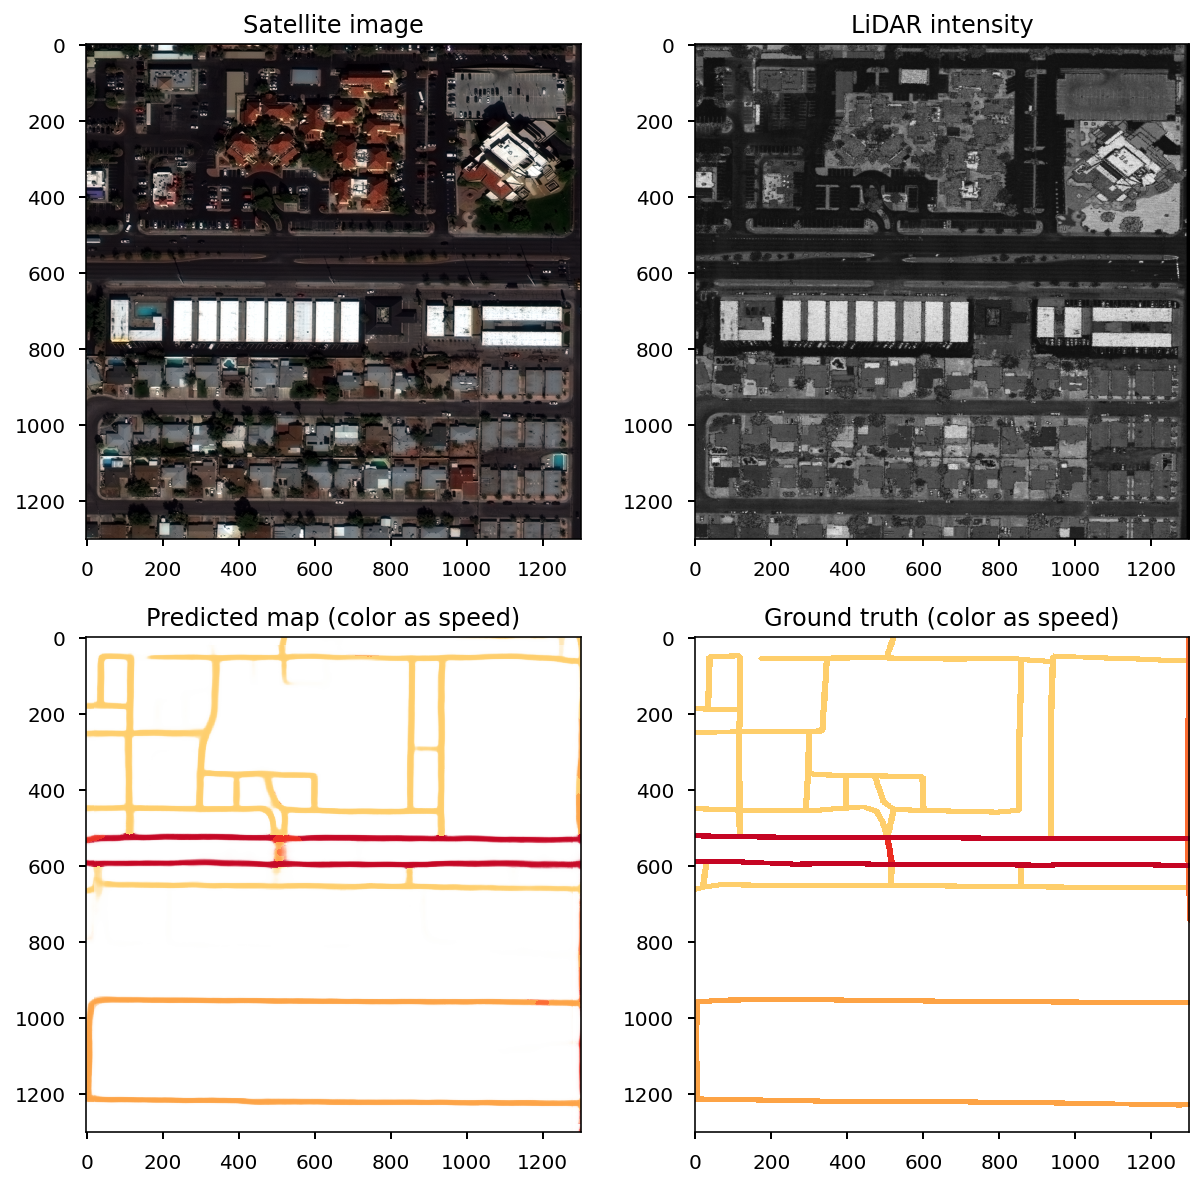

In [97]:
# Load input data
img = skimage.io.imread(img_path)
rgb = img[..., :3]
inten = img[..., -1]

# Load ground truth
mask_file = img_file.replace('RGB+INTEN', 'mask_roads_speed')
mask_path = os.path.join(mask_dir, mask_file)
mask = skimage.io.imread(mask_path)

# Load prediction result from the output directory
pred_file = img_file # same name as input image file
pred_dir = config['inference']['output_dir']
pred_path = os.path.join(pred_dir, pred_file)
pred = skimage.io.imread(pred_path)

# Prepare for multi-class visualization
pred_class = np.argmax(pred[..., :-1], axis=-1) # discard the last aggregated channel
pred_color = np.array(speed_colors)[pred_class]
pred_alpha = pred[..., -1] # aggregated likelihood as alpha

# Display satellite image, LiDAR, prediction mask, and ground truth mask.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('Satellite image')
ax[0][1].imshow(inten, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LiDAR intensity')
ax[1][0].imshow(pred_color, alpha=pred_alpha, **road_mask_params)
ax[1][0].set_title('Predicted map (color as speed)')
ax[1][1].imshow(mask, alpha=(mask>0).astype('float'), **road_mask_params)
ax[1][1].set_title('Ground truth (color as speed)')
fig.show()

### End of Demo